Extracted Features Shape: (80, 66)
After SMOTE, the shape of X: (80, 65)
After SMOTE, the shape of y: (80,)
Shape after PCA: (80, 26)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimator

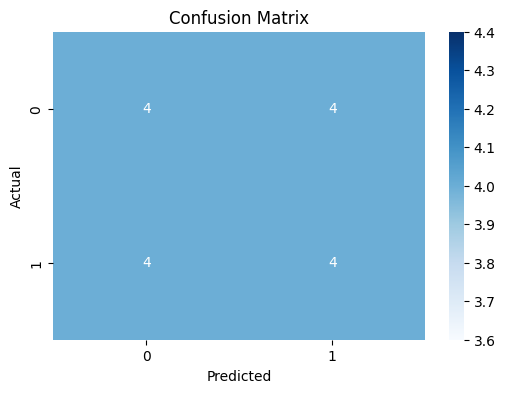

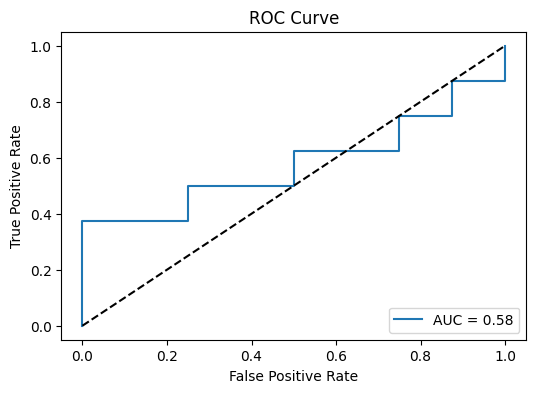

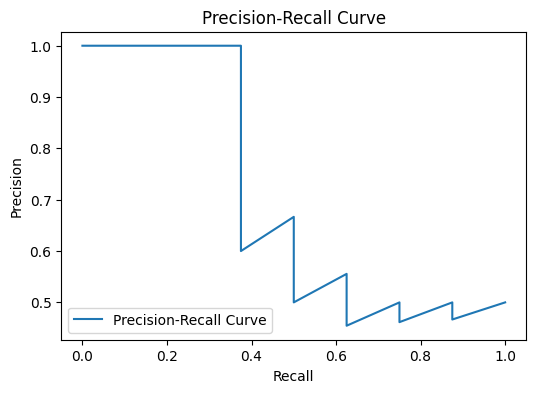

Model, Scaler, and PCA saved successfully!
Epoch 1/100
2/2 - 1s - 634ms/step - accuracy: 0.4118 - loss: 0.7250 - val_accuracy: 0.3846 - val_loss: 0.7190
Epoch 2/100
2/2 - 0s - 16ms/step - accuracy: 0.4510 - loss: 0.7510 - val_accuracy: 0.3846 - val_loss: 0.7398
Epoch 3/100
2/2 - 0s - 16ms/step - accuracy: 0.5686 - loss: 0.6723 - val_accuracy: 0.3846 - val_loss: 0.7342
Epoch 4/100
2/2 - 0s - 16ms/step - accuracy: 0.4902 - loss: 0.6933 - val_accuracy: 0.3846 - val_loss: 0.7192
Epoch 5/100
2/2 - 0s - 16ms/step - accuracy: 0.5098 - loss: 0.6963 - val_accuracy: 0.3846 - val_loss: 0.6997
Epoch 6/100
2/2 - 0s - 16ms/step - accuracy: 0.5686 - loss: 0.6714 - val_accuracy: 0.5385 - val_loss: 0.6884
Epoch 7/100
2/2 - 0s - 16ms/step - accuracy: 0.5686 - loss: 0.6682 - val_accuracy: 0.4615 - val_loss: 0.6810
Epoch 8/100
2/2 - 0s - 16ms/step - accuracy: 0.5490 - loss: 0.6892 - val_accuracy: 0.4615 - val_loss: 0.6791
Epoch 9/100
2/2 - 0s - 16ms/step - accuracy: 0.6471 - loss: 0.6431 - val_accuracy: 0

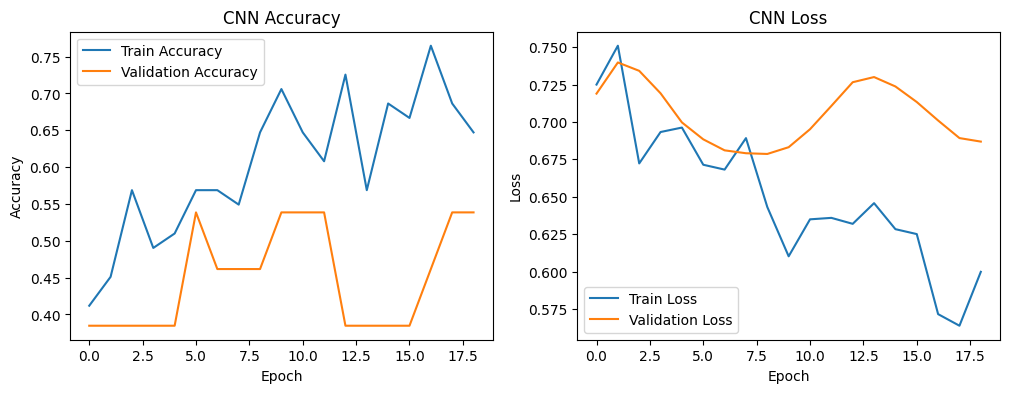

CNN Model saved successfully!


In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Directory paths
base_path = 'PhishingVoiceDataset'
phishing_path = os.path.join(base_path, 'Phishing')
non_phishing_path = os.path.join(base_path, 'NonPhishing')

# Function to extract features
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=3.0)  # Ensuring uniform duration
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Extract Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        spec_contrast_mean = np.mean(spec_contrast.T, axis=0)
        
        # Extract Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
        tonnetz_mean = np.mean(tonnetz.T, axis=0)
        
        # Concatenate all features
        feature_vector = np.hstack([mfccs_mean, chroma_mean, spec_contrast_mean, tonnetz_mean])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    return feature_vector

# Parse files and extract features
features = []
labels = []

for folder, label in [(phishing_path, 1), (non_phishing_path, 0)]:
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if file_path.endswith('.mp3'):
            mfccs = extract_features(file_path)
            if mfccs is not None:
                features.append(mfccs)
                labels.append(label)

# Convert into Pandas DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

print(f"Extracted Features Shape: {features_df.shape}")

# Handling Class Imbalance using SMOTE
X = features_df.drop('label', axis=1)
y = features_df['label']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f"After SMOTE, the shape of X: {X_res.shape}")
print(f"After SMOTE, the shape of y: {y_res.shape}")

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Shape after PCA: {X_pca.shape}")

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Hyperparameter Tuning with GridSearchCV for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

# Model Evaluation
y_pred = best_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_pred_proba = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Save the trained model and scaler
joblib.dump(best_rf, 'random_forest_phishing_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
print("Model, Scaler, and PCA saved successfully!")

# Advanced Model: Convolutional Neural Network (CNN)

# Reshape data for CNN
# Assuming each feature vector can be reshaped into a 2D array
# For simplicity, we'll reshape each sample to have 1 channel
# You might need to adjust the shape based on your actual feature dimensions

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3,1), activation='relu', input_shape=(X_train.shape[1],1,1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3,1), activation='relu'),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"CNN Model Accuracy: {accuracy * 100:.2f}%")

# Plotting Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the CNN model
cnn_model.save('cnn_phishing_model.h5')
print("CNN Model saved successfully!")
